# Autoregressive HMM on example session

In [2]:

""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
import seaborn as sns
from collections import defaultdict
import pandas as pd

from one.api import ONE
from jax import vmap
from pprint import pprint
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
# from dynamax.hidden_markov_model import GaussianHMM
from dynamax.hidden_markov_model import LinearAutoregressiveHMM
from dynamax.utils.plotting import gradient_cmap
from dynamax.utils.utils import random_rotation

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//2_fit_models/'
#functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import idxs_from_files, prepro_design_matrix, concatenate_sessions, fix_discontinuities
from fitting_functions import cross_validate_armodel, compute_inputs
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//3_postprocess_results/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)

from postprocessing_functions import remove_states_str, best__kappa, best_lag_kappa, state_identifiability, align_bin_design_matrix, states_per_trial_phase
from plotting_functions import plot_avg_state, plot_states_aligned_trial, plot_states_aligned, traces_over_few_sates

one = ONE(mode='remote')

## Parameters

In [24]:
bin_size = 0.1
bin_size = 0.02
# bin_size = 0.017
multiplier = 1/bin_size
# multiplier = 1

event_type_list = ['goCueTrigger_times']  # , 'feedback_times', 'firstMovement_times'
event_type_name = ['Go cue']  # , 'Feedback time', 'First movement onset'


num_iters = 100
num_train_batches = 5
method = 'kmeans'
threshold = 0.05
sticky = False
num_states = 2

num_lags = 3 # First order ARHMM
kappa = 10

var_interest = 'avg_wheel_vel'

# Values for grid search (should get this from results)
last_lag = 20
lag_step = 2
start_lag = 1
Lags = list(range(start_lag, last_lag, lag_step))
if sticky:
    kappas = [1, 5, 10, 100, 500, 1000, 2000, 5000, 7000, 10000]
else:
    kappas = [0, 1, 5, 10, 100, 500, 1000, 2000, 5000, 7000, 10000]

## Get data

In [37]:
data_file = "preprocessed_data_v4_170724"

if data_file == "preprocessed_data_v4_170724":
    use_sets = [['avg_wheel_vel'], ['Lick count'], ['whisker_me'],
                ['left_X', 'left_Y', 'right_X', 'right_Y'], ['nose_X', 'nose_Y']]
    var_interest_map = ['avg_wheel_vel', 'Lick count', 'whisker_me', 'left_X', 'nose_X']
    idx_init_list = [0, 1, 2, 3, 7]
    idx_end_list = [1, 2, 3, 7, 9]
    
    # Load preprocessed data
    prepro_results_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/90_trials/' + str(bin_size) + '/'
    idxs, mouse_names, matrix_all, matrix_all_unnorm, session_all = pickle.load(open(prepro_results_path + data_file, "rb"))
    collapsed_matrices, collapsed_unnorm, collapsed_trials = concatenate_sessions (mouse_names, matrix_all, matrix_all_unnorm, session_all)
    
elif data_file == "preprocessed_data_v4_171224_alltrials":
    use_sets = [['avg_wheel_vel'], ['whisker_me'], ['Lick count']]
    var_interest_map = ['avg_wheel_vel', 'whisker_me', 'Lick count']
    idx_init_list = [0, 1, 2]
    idx_end_list = [1, 2, 3]
    
    # Load preprocessed data
    prepro_results_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/' + str(bin_size) + '/'
    idxs, mouse_names, matrix_all, matrix_all_unnorm, session_all = pickle.load(open(prepro_results_path + data_file, "rb"))
    collapsed_matrices, collapsed_unnorm, collapsed_trials = concatenate_sessions (mouse_names, matrix_all, matrix_all_unnorm, session_all)

elif data_file == "preprocessed_data_v5_01-20-2025":
    use_sets = [['avg_wheel_vel'], ['whisker_me'], ['Lick count'], ['0.25', '0.5',
       '1.0', '2.0', '4.0', '8.0', '16.0']]
    var_interest_map = ['avg_wheel_vel', 'whisker_me', 'Lick count', '0.25', '0.5',
       '1.0', '2.0', '4.0', '8.0', '16.0']
    idx_init_list = [0, 1, 2, 3]
    idx_end_list = [1, 2, 3, 9]
    
    # Load preprocessed data
    prepro_results_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/' + str(bin_size) + '/'
    filename = prepro_results_path + data_file
    idxs, mouse_names, matrix_all, matrix_all_unnorm, session_all = pickle.load(open(filename, "rb"))
    collapsed_matrices, collapsed_unnorm, collapsed_trials = concatenate_sessions (mouse_names, matrix_all, matrix_all_unnorm, session_all)


## Fit best params on concatenated sessions

In [6]:
for m, mouse_name in enumerate(np.unique(mouse_names)[0:1]):

    index_var = np.where(np.array(var_interest_map)==var_interest)[0][0]
    idx_init = idx_init_list[index_var]
    idx_end = idx_end_list[index_var]
    var_names = use_sets[index_var]
    # mouse_name = 'CSHL049'
    # Get mouse data
    session_trials = collapsed_trials[mouse_name]
    design_matrix = collapsed_matrices[mouse_name][:,idx_init:idx_end]
    unnorm_mat = collapsed_unnorm[mouse_name][var_names]
    unnorm_mat['Bin'] = collapsed_unnorm[mouse_name]['Bin']
    
    # Get results from grid search
    results_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/90_trials/' + str(bin_size) + '/grid_search/concatenated/'
    os.chdir(results_path)
    files = os.listdir()
    if sticky == True:
        filename = "best_sticky_results_" + var_names[0] + '_' + mouse_name
    else:
        filename = "best_results_" + var_names[0] + '_' + mouse_name
    
    if filename in files:
        try:
            all_lls, all_baseline_lls, all_init_params, all_fit_params, _, kappas, Lags = pickle.load(open(filename, "rb"))

            # Prepare data format
            num_timesteps = np.shape(design_matrix)[0]
            emission_dim = np.shape(design_matrix)[1]
            shortened_array = np.array(design_matrix[:(num_timesteps // num_train_batches) * num_train_batches])
            train_emissions = jnp.stack(jnp.split(shortened_array, num_train_batches))
            
            # Get best params and fold
            best_lag, best_kappa, mean_bits_LL, best_fold = best_lag_kappa(all_lls, all_baseline_lls, design_matrix, num_train_batches, kappas, Lags)
            index_lag = np.where(np.array(Lags)==best_lag)[0][0]
            index_kappa = np.where(np.array(kappas)==best_kappa)[0][0]
            use_fold = int(best_fold[index_lag, index_kappa])
            best_kappa = 1
            
            " Fit model with best params"
            # Compute inputs for required timelags
            my_inputs = compute_inputs(shortened_array, best_lag, emission_dim)
            train_inputs = jnp.stack(jnp.split(my_inputs, num_train_batches))
            
            best_params = all_fit_params[best_lag][best_kappa]
            
            # Find parameters for best fold
            initial_probs = best_params[0].probs[use_fold]
            transition_matrix = best_params[1].transition_matrix[use_fold]
            emission_weights = best_params[2].weights[use_fold]
            emission_biases = best_params[2].biases[use_fold]
            emission_covariances = best_params[2].covs[use_fold]        
            
            # Initialize new hmm
            new_arhmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags=best_lag, transition_matrix_stickiness=best_kappa)
            best_fold_params, props = new_arhmm.initialize(key=jr.PRNGKey(0), method=method,
                                            initial_probs=initial_probs,
                                            transition_matrix=transition_matrix,               
                                            emission_weights=emission_weights,
                                            emission_biases=emission_biases, 
                                            emission_covariances=emission_covariances,
                                            emissions=shortened_array)  # not sure if I need to include  
            
            # Get state estimates for validation data
            most_likely_states = new_arhmm.most_likely_states(best_fold_params, shortened_array, my_inputs)

            # Keep only enough states to explain 95% observations
            unique, counts = np.unique(most_likely_states, return_counts=True)
            threshold_count = threshold * len(most_likely_states)
            excluded_bins = 0
            remaining_states = list(counts.copy())
            for state in unique:
                size_smallest_state = np.nanmin(remaining_states)
                if size_smallest_state + excluded_bins < threshold_count:
                    remaining_states[np.where(counts==size_smallest_state)[0][0]] = np.nan
                    excluded_bins += size_smallest_state
            
            # Remove states below threshold
            new_states = np.array(most_likely_states).astype(float)
            exclude_states = np.where(np.isnan(np.array(remaining_states)))[0].astype(float)
            # Create a boolean mask to identify values to replace
            mask = np.isin(new_states, exclude_states)
            # Replace values in main_array with np.nan using the boolean mask
            new_states[mask] = np.nan
            
            
            new_states = most_likely_states
            
            " Plots "
            # Prepare data
            design_matrix_heading = pd.DataFrame(columns=var_names)
            design_matrix_heading[var_names] = design_matrix[0:len(most_likely_states)]  # TODO: need to understand why number is the same and whether it depends on lag
            bins = unnorm_mat[:(num_timesteps // num_train_batches) * num_train_batches]['Bin']
            design_matrix_heading['Bin'] = bins
            
            # Fix discontinuities
            cont_trials, cont_design_matrix_heading = fix_discontinuities(session_trials, design_matrix_heading, multiplier)
            
            # Align bins
            init = -1 * multiplier
            end = 1.5 * multiplier
            empirical_data = align_bin_design_matrix(init, end, event_type_list, cont_trials, cont_design_matrix_heading, new_states, multiplier)


            print(mouse_name)
            """ Stack trial states """
            trial_init = 30  # First trial to plot
            trials_to_plot = 20  # How many trials to plot (if very different will compromise readibility)
            plot_states_aligned_trial(trial_init, empirical_data, cont_trials, bin_size, trials_to_plot, num_states)

            " Plot states stacked and aligned per trial type "
            plot_states_aligned(init, end, empirical_data, event_type_name, bin_size)
            
            # """ Plot states per trial epoch """
            # colors = sns.color_palette("viridis", num_states)
            # # states_trial = states_per_trial_phase(empirical_data, session_trials, multiplier)
            # states_trial = states_per_trial_phase(empirical_data, cont_trials, multiplier)
            # sns.histplot(x='label', hue=0, data=states_trial, stat = 'percent',
            #                     multiple="stack", legend=True, palette='viridis', alpha=0.3)
            # plt.figure(figsize=[7, 5])
            # plt.xticks(rotation=45)
            # plt.tight_layout()
            # plt.title(mouse_name)
            # plt.show()

            """ Plot raw traces over states """
            init = 250*multiplier # First bin
            inter = 20*multiplier
            # traces_over_few_sates(init, empirical_data, session_trials, var_names)
            traces_over_few_sates(init, inter, empirical_data, cont_trials, var_names, multiplier)
                    
        except:
            print(mouse_name + 'not possible')


/tmp/ipykernel_17772/295397734.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = collapsed_unnorm[mouse_name]['Bin']


FileNotFoundError: [Errno 2] No such file or directory: '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/90_trials/0.02/grid_search/concatenated/'

# Fit best params on individual sessions

best_results_avg_wheel_vel_CSHL0457939711b-8b4d-4251-b698-b97c1eaa846e
1 1000


/tmp/ipykernel_17772/1709885482.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = matrix_all_unnorm[mouse_name][session]['Bin']
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: Mean of empty slice
  return f_raw(*args, **kwargs)
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learning_variability/Functions

CSHL045


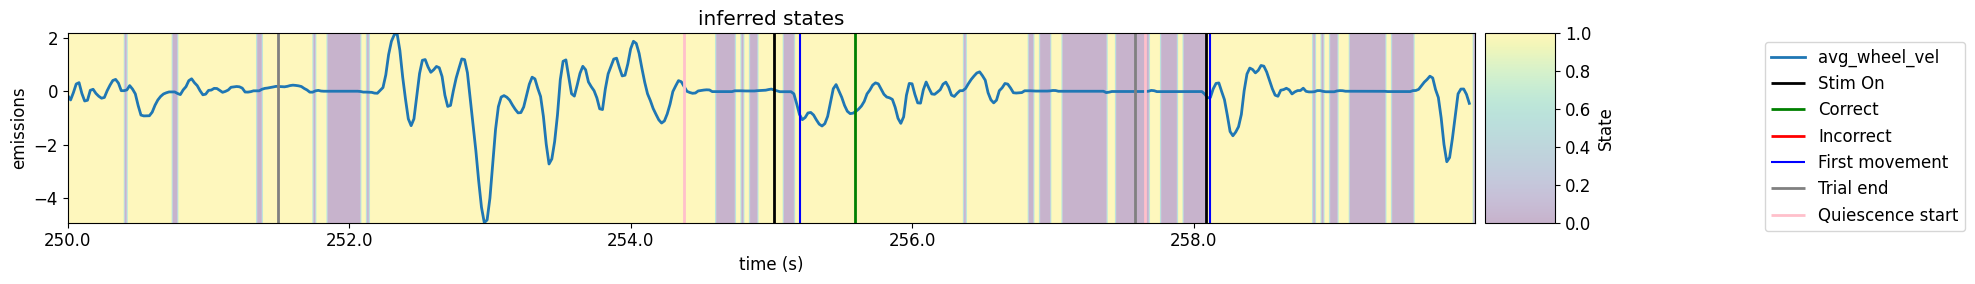

best_results_avg_wheel_vel_ibl_witten_255285c561-80da-4563-8694-739da92e5dd0


/tmp/ipykernel_17772/1709885482.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = matrix_all_unnorm[mouse_name][session]['Bin']


3 0


/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_feedback'][1:] = trials['feedbackType'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

ibl_witten_25


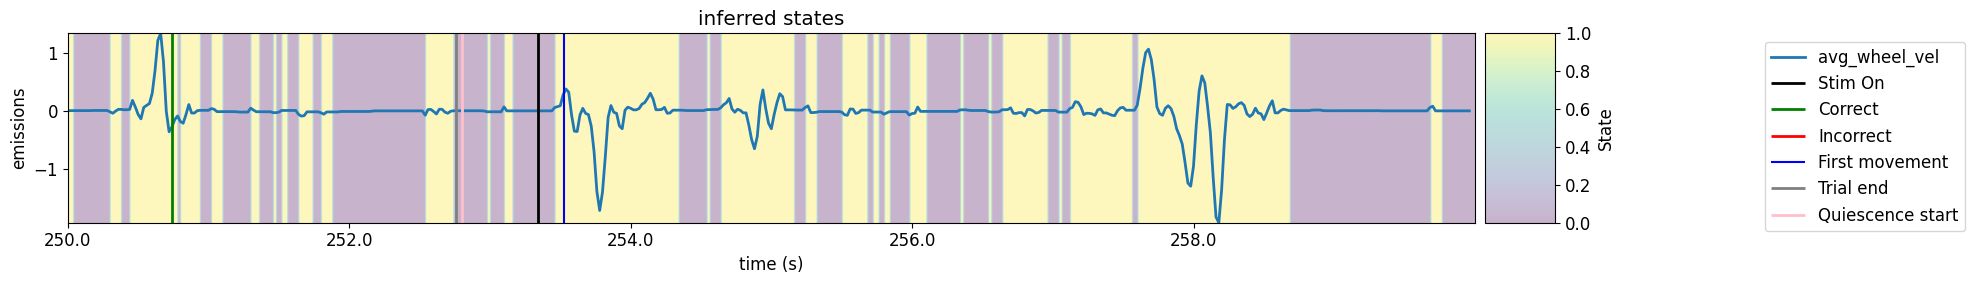

best_results_avg_wheel_vel_ibl_witten_2958b1e920-cfc8-467e-b28b-7654a55d0977
5 0


/tmp/ipykernel_17772/1709885482.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = matrix_all_unnorm[mouse_name][session]['Bin']
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documen

ibl_witten_29


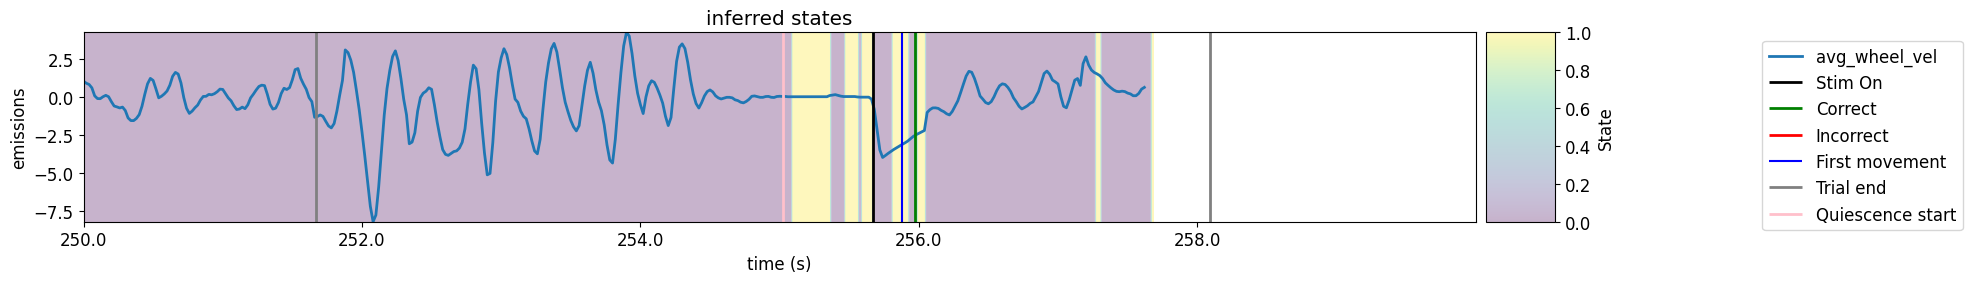

best_results_avg_wheel_vel_CSHL058fb70ebf7-8175-42b0-9b7a-7c6e8612226e
1 0.5


/tmp/ipykernel_17772/1709885482.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = matrix_all_unnorm[mouse_name][session]['Bin']
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: Mean of empty slice
  return f_raw(*args, **kwargs)
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learning_variability/Functions

CSHL058


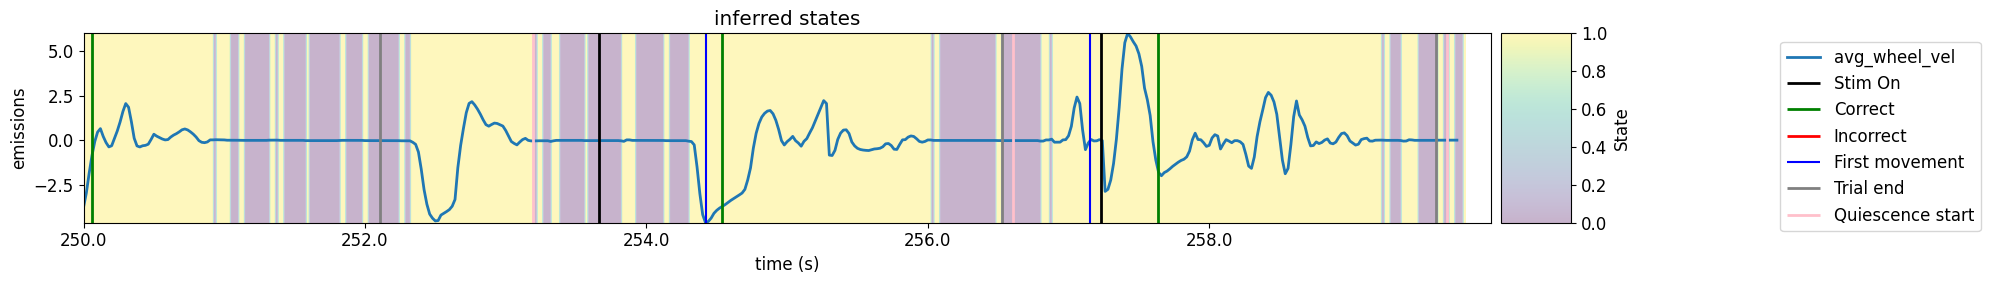

best_results_avg_wheel_vel_ibl_witten_29e9fc0a2d-c69d-44d1-9fa3-314782387cae
1 10000


/tmp/ipykernel_17772/1709885482.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = matrix_all_unnorm[mouse_name][session]['Bin']
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: Mean of empty slice
  return f_raw(*args, **kwargs)
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learning_variability/Functions

ibl_witten_29


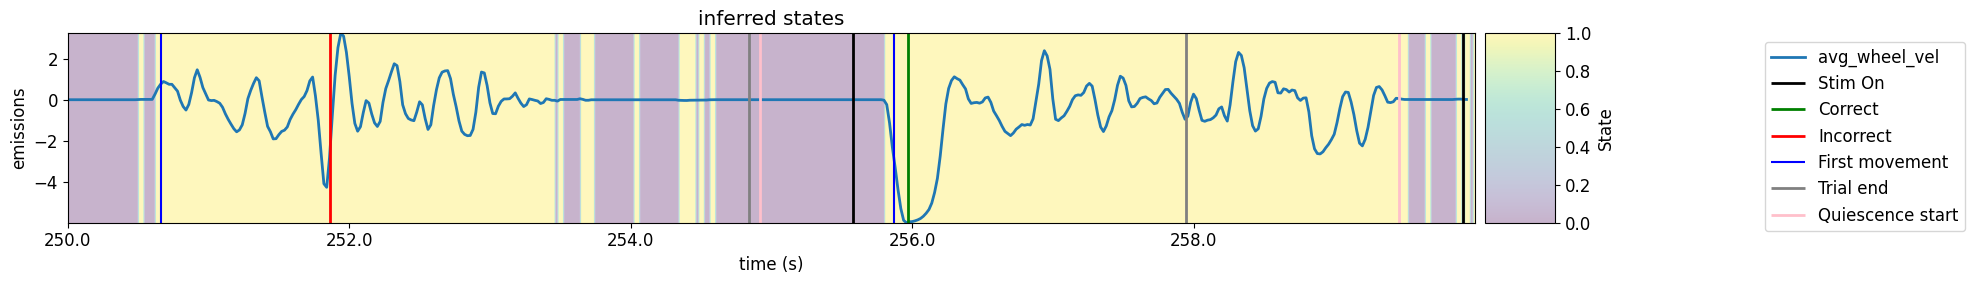

best_results_avg_wheel_vel_DY_016d23a44ef-1402-4ed7-97f5-47e9a7a504d9
13 0


/tmp/ipykernel_17772/1709885482.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = matrix_all_unnorm[mouse_name][session]['Bin']
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documen

DY_016


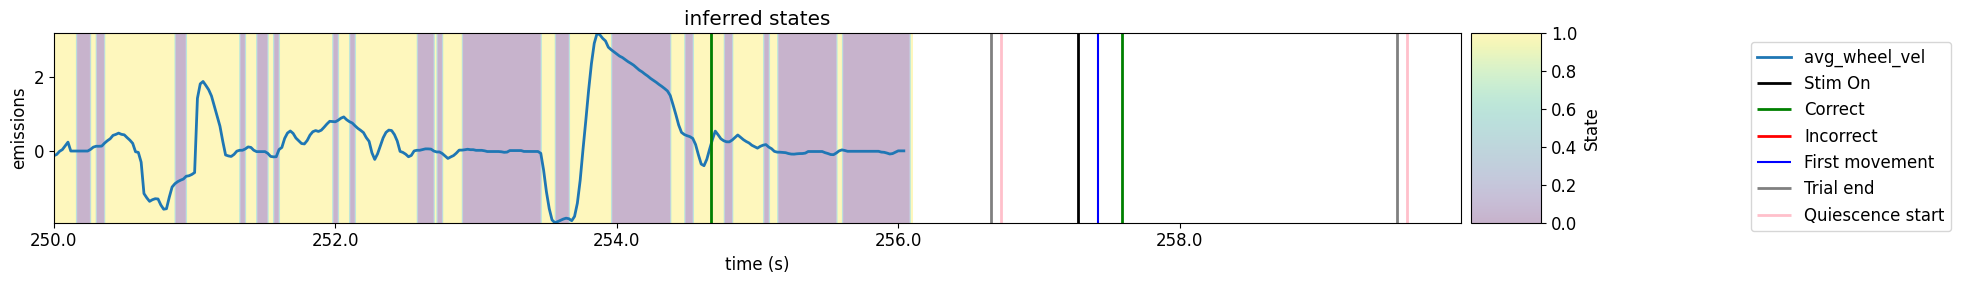

best_results_avg_wheel_vel_CSHL058f312aaec-3b6f-44b3-86b4-3a0c119c0438
1 10000


/tmp/ipykernel_17772/1709885482.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = matrix_all_unnorm[mouse_name][session]['Bin']
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documen

CSHL058


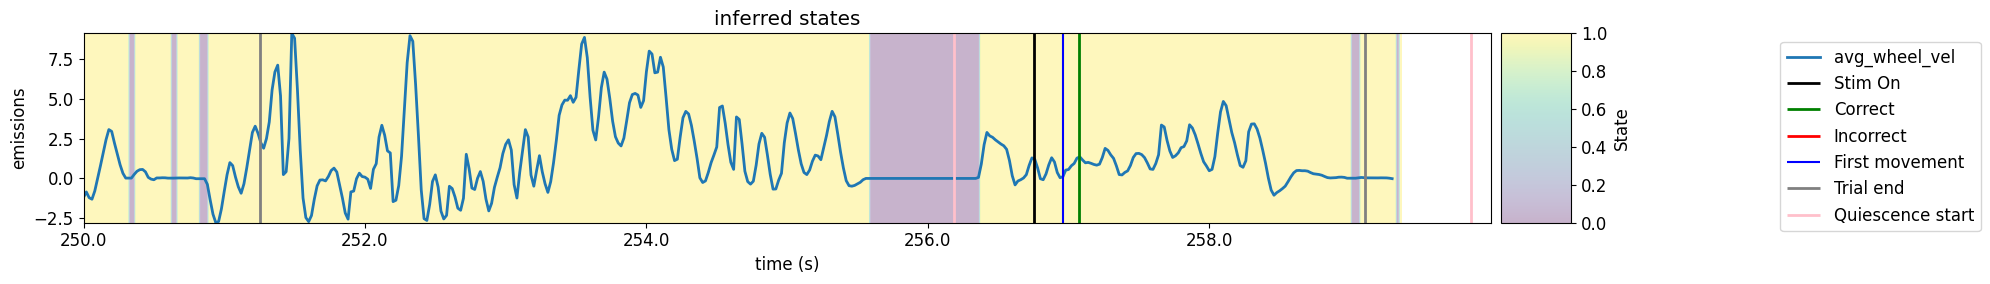

best_results_avg_wheel_vel_CSHL051ecb5520d-1358-434c-95ec-93687ecd1396
1 100


/tmp/ipykernel_17772/1709885482.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = matrix_all_unnorm[mouse_name][session]['Bin']
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: Mean of empty slice
  return f_raw(*args, **kwargs)
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learning_variability/Functions

CSHL051


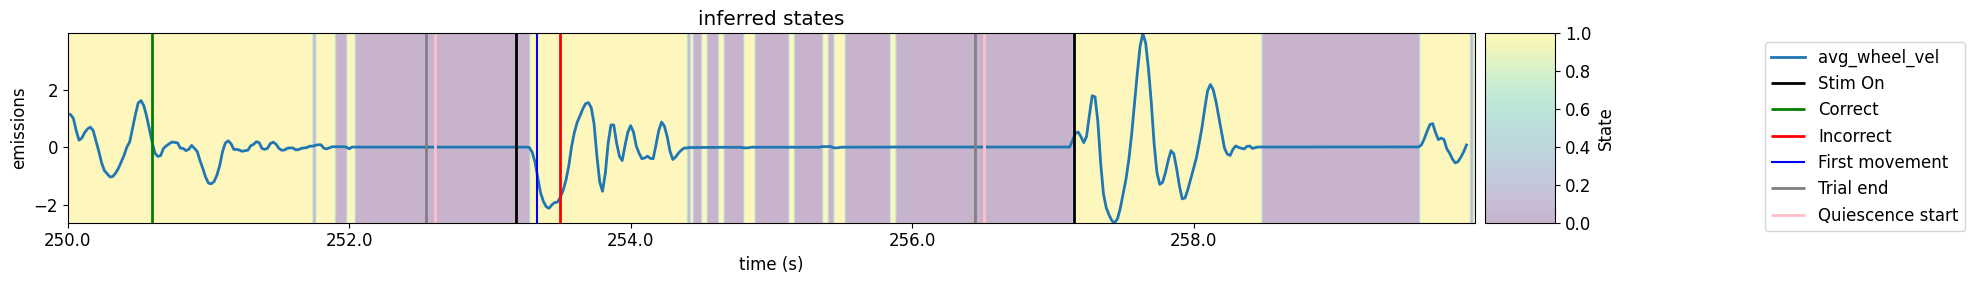

best_results_avg_wheel_vel_PL01564977c74-9c04-437a-9ea1-50386c4996db
5 0


/tmp/ipykernel_17772/1709885482.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = matrix_all_unnorm[mouse_name][session]['Bin']
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documen

PL015


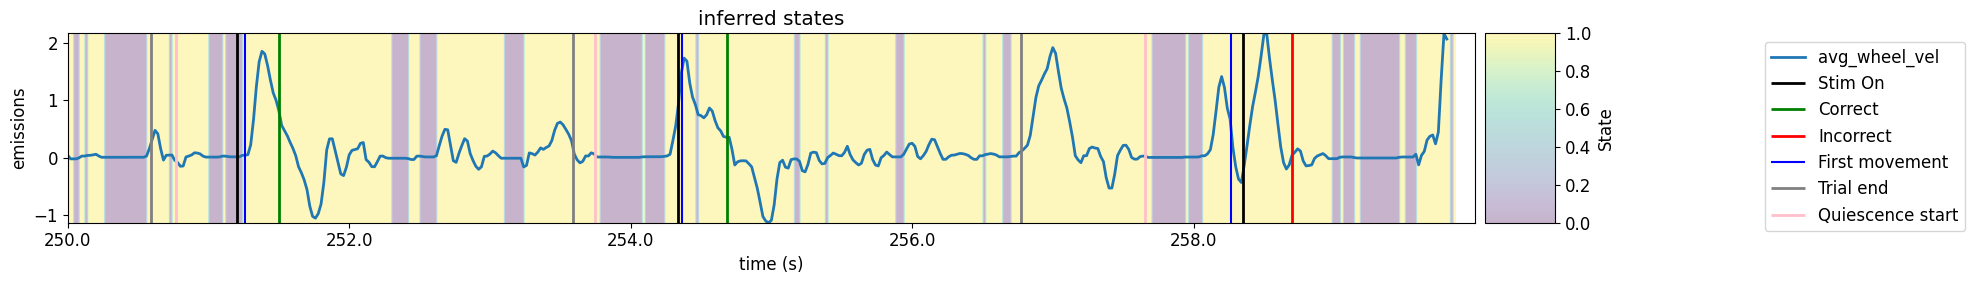

best_results_avg_wheel_vel_ZM_2240510b1a50-825d-44ce-86f6-9678f5396e02
5 0


/tmp/ipykernel_17772/1709885482.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = matrix_all_unnorm[mouse_name][session]['Bin']
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documen

ZM_2240


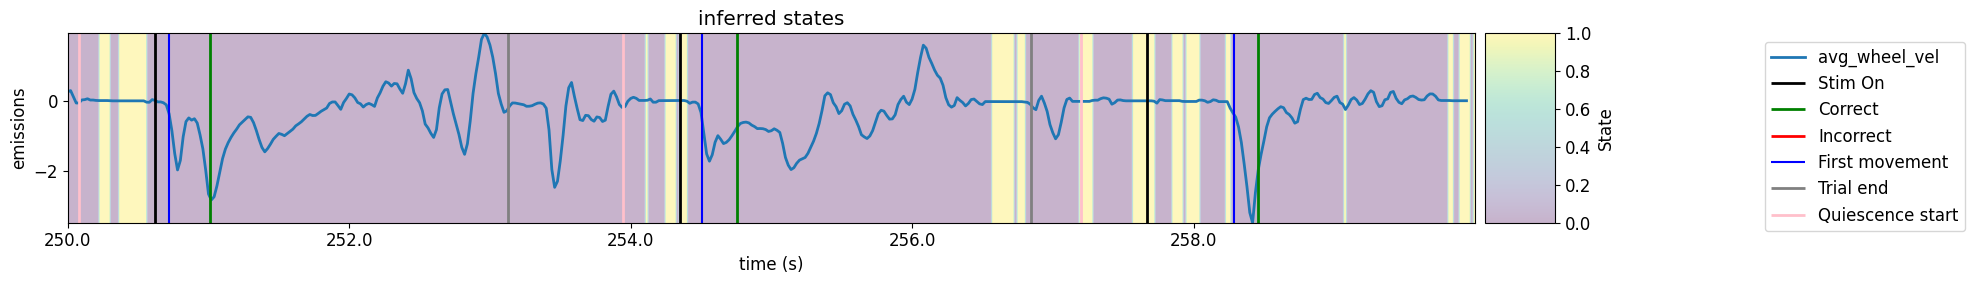

In [36]:
index_var = np.where(np.array(var_interest_map)==var_interest)[0][0]
idx_init = idx_init_list[index_var]
idx_end = idx_end_list[index_var]
var_names = use_sets[index_var]

for m, mat in enumerate(idxs[:10]): #
    if len(mat) > 35: 
        
        mouse_name = mat[37:]
        # mouse_name = 'ZM_3003'
        session = mat[0:36]
        # session = '934dd7a4-fbdc-459c-8830-04fe9033bc28'
        
        fit_id = str(mouse_name+session)
        if sticky:
            filename = "best_sticky_results_" + var_interest + '_' + fit_id
        else:
            filename = "best_results_" + var_interest + '_' + fit_id
        data_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/90_trials/' + str(bin_size) + '/'+str(num_states)+'_states/grid_search/individual_sessions/'
        os.chdir(data_path)
        files = os.listdir()
        
        if filename in files:
            print(filename)
            # Get mouse data
            session_trials = session_all[mouse_name][session].reset_index()
            design_matrix = matrix_all[mouse_name][session][:,idx_init:idx_end]
            unnorm_mat = matrix_all_unnorm[mouse_name][session][var_names]
            unnorm_mat['Bin'] = matrix_all_unnorm[mouse_name][session]['Bin']

            #try:
            all_lls, all_baseline_lls, all_init_params, all_fit_params, _, kappas, Lags = pickle.load(open(filename, "rb"))

            # Prepare data format
            num_timesteps = np.shape(design_matrix)[0]
            emission_dim = np.shape(design_matrix)[1]
            shortened_array = np.array(design_matrix[:(num_timesteps // num_train_batches) * num_train_batches])
            train_emissions = jnp.stack(jnp.split(shortened_array, num_train_batches))
            
            # Get best params and fold
            best_lag, best_kappa, mean_bits_LL, best_fold = best_lag_kappa(all_lls, all_baseline_lls, design_matrix, num_train_batches, kappas, Lags)

            # best_lag = 3
            # best_kappa = 10000
            index_lag = np.where(np.array(Lags)==best_lag)[0][0]
            index_kappa = np.where(np.array(kappas)==best_kappa)[0][0]
            use_fold = int(best_fold[index_lag, index_kappa])
            
            " Fit model with best params"
            # Compute inputs for required timelags
            my_inputs = compute_inputs(shortened_array, best_lag, emission_dim)
            train_inputs = jnp.stack(jnp.split(my_inputs, num_train_batches))
            
            best_params = all_fit_params[best_lag][best_kappa]
            print(best_lag, best_kappa)

            # Find parameters for best fold
            initial_probs = best_params[0].probs[use_fold]
            transition_matrix = best_params[1].transition_matrix[use_fold]
            emission_weights = best_params[2].weights[use_fold]
            emission_biases = best_params[2].biases[use_fold]
            emission_covariances = best_params[2].covs[use_fold]        
            
            # Initialize new hmm
            new_arhmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags=best_lag, transition_matrix_stickiness=best_kappa)
            best_fold_params, props = new_arhmm.initialize(key=jr.PRNGKey(0), method=method,
                                            initial_probs=initial_probs,
                                            transition_matrix=transition_matrix,               
                                            emission_weights=emission_weights,
                                            emission_biases=emission_biases, 
                                            emission_covariances=emission_covariances,
                                            emissions=shortened_array)  # not sure if I need to include  
            
            # Get state estimates for validation data
            most_likely_states = new_arhmm.most_likely_states(best_fold_params, shortened_array, my_inputs)

            # Keep only enough states to explain 95% observations
            unique, counts = np.unique(most_likely_states, return_counts=True)
            threshold_count = threshold * len(most_likely_states)
            excluded_bins = 0
            remaining_states = list(counts.copy())
            for state in unique:
                size_smallest_state = np.nanmin(remaining_states)
                if size_smallest_state + excluded_bins < threshold_count:
                    remaining_states[np.where(counts==size_smallest_state)[0][0]] = np.nan
                    excluded_bins += size_smallest_state
            
            # Remove states below threshold
            new_states = np.array(most_likely_states).astype(float)
            exclude_states = np.where(np.isnan(np.array(remaining_states)))[0].astype(float)
            # Create a boolean mask to identify values to replace
            mask = np.isin(new_states, exclude_states)
            # Replace values in main_array with np.nan using the boolean mask
            new_states[mask] = np.nan
            
            
            new_states = most_likely_states
            
            " Plots "
            # Prepare data
            design_matrix_heading = pd.DataFrame(columns=var_names)
            design_matrix_heading[var_names] = design_matrix[0:len(most_likely_states)]  # TODO: need to understand why number is the same and whether it depends on lag
            bins = unnorm_mat[:(num_timesteps // num_train_batches) * num_train_batches]['Bin']
            design_matrix_heading['Bin'] = bins
            
            # Fix discontinuities
            cont_trials, cont_design_matrix_heading = fix_discontinuities(session_trials, design_matrix_heading, multiplier)
            
            # Align bins
            init = -1 * multiplier
            end = 1.5 * multiplier
            empirical_data = align_bin_design_matrix(init, end, event_type_list, cont_trials, cont_design_matrix_heading, new_states, multiplier)


            print(mouse_name)
            """ Stack trial states """
            trial_init = 0  # First trial to plot
            trials_to_plot = 20  # How many trials to plot (if very different will compromise readibility)
            inverted_mapping = []
            # plot_states_aligned_trial(trial_init, empirical_data, cont_trials, bin_size, trials_to_plot, inverted_mapping)

            # " Plot states stacked and aligned per trial type "
            # plot_states_aligned(init, end, empirical_data, event_type_name, bin_size, inverted_mapping)
            
            """ Plot states per trial epoch """
            # colors = sns.color_palette("viridis", num_states)
            # # states_trial = states_per_trial_phase(empirical_data, session_trials, multiplier)
            # states_trial = states_per_trial_phase(empirical_data, cont_trials, multiplier)
            # sns.histplot(x='label', hue=0, data=states_trial, stat = 'percent',
            #                     multiple="stack", legend=True, palette='viridis', alpha=0.3)
            # # plt.figure(figsize=[7, 5])
            # plt.xticks(rotation=45)
            # plt.tight_layout()
            
            # plt.title(mouse_name)
            # plt.show()

            """ Plot raw traces over states """
            init = 250*multiplier # First bin
            inter = 10*multiplier
            # traces_over_few_sates(init, empirical_data, session_trials, var_names)
            traces_over_few_sates(init, inter, empirical_data, cont_trials, var_names, multiplier, inverted_mapping)
                        
            #except:
            #    print(mat + 'not possible')

In [30]:
empirical_data

,avg_wheel_vel,Bin,most_likely_states,new_bin,correct,choice,contrast,block,reaction,response,elongation,wsls,trial_id,goCueTrigger_times
0,-0.007304,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.007304,1403.0,0,0.0,1.0,right,1.0,0.5,0.1418,0.444387,0.091909,NaN,0.0,28.042916
2,-0.007304,1404.0,0,1.0,1.0,right,1.0,0.5,0.1418,0.444387,0.091909,NaN,0.0,28.042916
3,-0.007304,1405.0,0,2.0,1.0,right,1.0,0.5,0.1418,0.444387,0.091909,NaN,0.0,28.042916
4,-0.026494,1406.0,0,3.0,1.0,right,1.0,0.5,0.1418,0.444387,0.091909,NaN,0.0,28.042916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32695,0.556683,35166.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32696,0.705570,35167.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32697,0.468466,35168.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32698,0.128209,35169.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
index_var = np.where(np.array(var_interest_map)==var_interest)[0][0]
idx_init = idx_init_list[index_var]
idx_end = idx_end_list[index_var]
var_names = use_sets[index_var]

for m, mat in enumerate(idxs): #
    if len(mat) > 35: 
        
        mouse_name = mat[37:]
        # mouse_name = 'ZM_3003'
        session = mat[0:36]
        # session = '934dd7a4-fbdc-459c-8830-04fe9033bc28'
        
        fit_id = str(mouse_name+session)
        if sticky:
            filename = "best_sticky_results_" + var_interest + '_' + fit_id
        else:
            filename = "best_results_" + var_interest + '_' + fit_id   
        data_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/' + str(bin_size) + '/'+str(num_states)+'_states/grid_search/individual_sessions/'
        os.chdir(data_path)
        files = os.listdir()
        
        if filename in files:
            print(filename)
            # Get mouse data
            session_trials = session_all[mouse_name][session].reset_index()
            design_matrix = matrix_all[mouse_name][session][:,idx_init:idx_end]
            unnorm_mat = matrix_all_unnorm[mouse_name][session][var_names]
            unnorm_mat['Bin'] = matrix_all_unnorm[mouse_name][session]['Bin']

            #try:
            all_lls, all_baseline_lls, all_init_params, all_fit_params, _, kappas, Lags = pickle.load(open(filename, "rb"))

            # Prepare data format
            num_timesteps = np.shape(design_matrix)[0]
            emission_dim = np.shape(design_matrix)[1]
            shortened_array = np.array(design_matrix[:(num_timesteps // num_train_batches) * num_train_batches])
            train_emissions = jnp.stack(jnp.split(shortened_array, num_train_batches))
            
            # Get best params and fold
            best_lag, best_kappa, mean_bits_LL, best_fold = best_lag_kappa(all_lls, all_baseline_lls, design_matrix, num_train_batches, kappas, Lags)

            
            index_lag = np.where(np.array(Lags)==best_lag)[0][0]
            index_kappa = np.where(np.array(kappas)==best_kappa)[0][0]
            use_fold = int(best_fold[index_lag, index_kappa])
            
            " Fit model with best params"
            # Compute inputs for required timelags
            my_inputs = compute_inputs(shortened_array, best_lag, emission_dim)
            train_inputs = jnp.stack(jnp.split(my_inputs, num_train_batches))
            
            best_params = all_fit_params[best_lag][best_kappa]
            print(best_lag, best_kappa)
            # Find parameters for best fold
            initial_probs = best_params[0].probs[use_fold]
            transition_matrix = best_params[1].transition_matrix[use_fold]
            emission_weights = best_params[2].weights[use_fold]
            emission_biases = best_params[2].biases[use_fold]
            emission_covariances = best_params[2].covs[use_fold]        
            
            # Initialize new hmm
            new_arhmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags=best_lag, transition_matrix_stickiness=best_kappa)
            best_fold_params, props = new_arhmm.initialize(key=jr.PRNGKey(0), method=method,
                                            initial_probs=initial_probs,
                                            transition_matrix=transition_matrix,               
                                            emission_weights=emission_weights,
                                            emission_biases=emission_biases, 
                                            emission_covariances=emission_covariances,
                                            emissions=shortened_array)  # not sure if I need to include  
            
            # Get state estimates for validation data
            most_likely_states = new_arhmm.most_likely_states(best_fold_params, shortened_array, my_inputs)

            # Keep only enough states to explain 95% observations
            unique, counts = np.unique(most_likely_states, return_counts=True)
            threshold_count = threshold * len(most_likely_states)
            excluded_bins = 0
            remaining_states = list(counts.copy())
            for state in unique:
                size_smallest_state = np.nanmin(remaining_states)
                if size_smallest_state + excluded_bins < threshold_count:
                    remaining_states[np.where(counts==size_smallest_state)[0][0]] = np.nan
                    excluded_bins += size_smallest_state
            
            # Remove states below threshold
            new_states = np.array(most_likely_states).astype(float)
            exclude_states = np.where(np.isnan(np.array(remaining_states)))[0].astype(float)
            # Create a boolean mask to identify values to replace
            mask = np.isin(new_states, exclude_states)
            # Replace values in main_array with np.nan using the boolean mask
            new_states[mask] = np.nan
            
            
            new_states = most_likely_states
            
            " Plots "
            # Prepare data
            design_matrix_heading = pd.DataFrame(columns=var_names)
            design_matrix_heading[var_names] = design_matrix[0:len(most_likely_states)]  # TODO: need to understand why number is the same and whether it depends on lag
            bins = unnorm_mat[:(num_timesteps // num_train_batches) * num_train_batches]['Bin']
            design_matrix_heading['Bin'] = bins
            
            # Fix discontinuities
            cont_trials, cont_design_matrix_heading = fix_discontinuities(session_trials, design_matrix_heading, multiplier)
            
            # Align bins
            init = -1 * multiplier
            end = 1.5 * multiplier
            empirical_data = align_bin_design_matrix(init, end, event_type_list, cont_trials, cont_design_matrix_heading, new_states, multiplier)


            print(mouse_name)
            """ Stack trial states """
            trial_init = 0  # First trial to plot
            trials_to_plot = 20  # How many trials to plot (if very different will compromise readibility)
            inverted_mapping = []
            plot_states_aligned_trial(trial_init, empirical_data, cont_trials, bin_size, trials_to_plot, inverted_mapping)

            " Plot states stacked and aligned per trial type "
            plot_states_aligned(init, end, empirical_data, event_type_name, bin_size, inverted_mapping)
            
            # """ Plot states per trial epoch """
            # colors = sns.color_palette("viridis", num_states)
            # # states_trial = states_per_trial_phase(empirical_data, session_trials, multiplier)
            # states_trial = states_per_trial_phase(empirical_data, cont_trials, multiplier)
            # sns.histplot(x='label', hue=0, data=states_trial, stat = 'percent',
            #                     multiple="stack", legend=True, palette='viridis', alpha=0.3)
            # # plt.figure(figsize=[7, 5])
            # plt.xticks(rotation=45)
            # plt.tight_layout()
            
            # plt.title(mouse_name)
            # plt.show()

            """ Plot raw traces over states """
            init = 250*multiplier # First bin
            inter = 20*multiplier
            # traces_over_few_sates(init, empirical_data, session_trials, var_names)
            traces_over_few_sates(init, inter, empirical_data, cont_trials, var_names, multiplier, inverted_mapping)
                        
            #except:
            #    print(mat + 'not possible')

FileNotFoundError: [Errno 2] No such file or directory: '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/0.02/2_states/grid_search/individual_sessions/'

## Fit concatenated sessions

In [9]:
for m, mouse_name in enumerate(np.unique(mouse_names)):
    try:               
        # mouse_name = 'NYU-45'
        index_var = np.where(np.array(var_interest_map)==var_interest)[0][0]
        idx_init = idx_init_list[index_var]
        idx_end = idx_end_list[index_var]
        var_names = use_sets[index_var]
        
        # Get mouse data
        session_trials = collapsed_trials[mouse_name]
        design_matrix = collapsed_matrices[mouse_name][:,idx_init:idx_end]
        unnorm_mat = collapsed_unnorm[mouse_name][var_names]
        unnorm_mat['Bin'] = collapsed_unnorm[mouse_name]['Bin']
        
        " Fit model with cross-validation"
        # Prepare data for cross-validation
        num_timesteps = np.shape(design_matrix)[0]
        emission_dim = np.shape(design_matrix)[1]
        shortened_array = np.array(design_matrix[:(num_timesteps // num_train_batches) * num_train_batches])
        train_emissions = jnp.stack(jnp.split(shortened_array, num_train_batches))
        
        # Initialize model with Kmeans
        test_arhmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags=num_lags, transition_matrix_stickiness=kappa)
        init_params, props = test_arhmm.initialize(key=jr.PRNGKey(1), method=method, emissions=shortened_array)  # for now all data
        
        # Compute inputs for required timelags
        my_inputs = compute_inputs(shortened_array, num_lags, emission_dim)
        train_inputs = jnp.stack(jnp.split(my_inputs, num_train_batches))
        
        # Fit model to all data with cross-validation
        val_lls, fit_params, init_params, baseline_lls = cross_validate_armodel(test_arhmm, 
                                                                                jr.PRNGKey(0), shortened_array, train_emissions, train_inputs, method, num_train_batches)

        " Re-fit with parameters of best fold "
        # Find best fold
        use_fold = np.where(val_lls==np.nanmax(val_lls))[0][0]
        print(use_fold)
        
        # Find parameters for best fold
        initial_probs = fit_params[0].probs[use_fold]
        transition_matrix = fit_params[1].transition_matrix[use_fold]
        emission_weights = fit_params[2].weights[use_fold]
        emission_biases = fit_params[2].biases[use_fold]
        emission_covariances = fit_params[2].covs[use_fold]        
        
        # Initialize new hmm
        new_arhmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags=num_lags)
        best_fold_params, props = new_arhmm.initialize(key=jr.PRNGKey(0), method=method,
                                        initial_probs=initial_probs,
                                        transition_matrix=transition_matrix,               
                                        emission_weights=emission_weights,
                                        emission_biases=emission_biases, 
                                        emission_covariances=emission_covariances,
                                        emissions=shortened_array)  # not sure if I need to include  
        
        # Get state estimates for validation data
        most_likely_states = new_arhmm.most_likely_states(best_fold_params, shortened_array, my_inputs)

        # Keep only enough states to explain 95% observations
        
        unique, counts = np.unique(most_likely_states, return_counts=True)
        threshold_count = threshold * len(most_likely_states)
        excluded_bins = 0
        remaining_states = list(counts.copy())
        for state in unique:
            size_smallest_state = np.nanmin(remaining_states)
            if size_smallest_state + excluded_bins < threshold_count:
                remaining_states[np.where(counts==size_smallest_state)[0][0]] = np.nan
                excluded_bins += size_smallest_state
        
        # Remove states below threshold
        new_states = np.array(most_likely_states).astype(float)
        exclude_states = np.where(np.isnan(np.array(remaining_states)))[0].astype(float)
        # Create a boolean mask to identify values to replace
        mask = np.isin(new_states, exclude_states)
        # Replace values in main_array with np.nan using the boolean mask
        new_states[mask] = np.nan

        new_states = most_likely_states
        
        " Plots "
        # Prepare data
        design_matrix_heading = pd.DataFrame(columns=var_names)
        design_matrix_heading[var_names] = design_matrix[0:len(most_likely_states)]  # TODO: need to understand why number is the same and whether it depends on lag
        bins = unnorm_mat[:(num_timesteps // num_train_batches) * num_train_batches]['Bin']
        design_matrix_heading['Bin'] = bins
        
        # Fix discontinuities
        cont_trials, cont_design_matrix_heading = fix_discontinuities(session_trials, design_matrix_heading, multiplier)
        
        # Align bins
        init = -1 * multiplier
        end = 1.5 * multiplier
        empirical_data = align_bin_design_matrix(init, end, event_type_list, cont_trials, cont_design_matrix_heading, new_states, multiplier)


        # """ Stack trial states """
        # trial_init = 30  # First trial to plot
        # trials_to_plot = 20  # How many trials to plot (if very different will compromise readibility)
        # plot_states_aligned_trial(trial_init, empirical_data, cont_trials, bin_size, trials_to_plot, num_states)

        # " Plot states stacked and aligned per trial type "
        # plot_states_aligned(init, end, empirical_data, event_type_name, bin_size)
        
        # """ Plot states per trial epoch """
        # colors = sns.color_palette("viridis", num_states)
        # # states_trial = states_per_trial_phase(empirical_data, session_trials, multiplier)
        # states_trial = states_per_trial_phase(empirical_data, cont_trials, multiplier)
        # sns.histplot(x='label', hue=0, data=states_trial, stat = 'percent',
        #                     multiple="stack", legend=True, palette='viridis', alpha=0.3)
        # plt.figure(figsize=[7, 5])
        # plt.xticks(rotation=45)
        # plt.tight_layout()
        # plt.title(mouse_name)
        # plt.show()

        """ Plot raw traces over states """
        init = 250*multiplier # First bin
        inter = 20*multiplier
        # traces_over_few_sates(init, empirical_data, session_trials, var_names)
        traces_over_few_sates(init, inter, empirical_data, cont_trials, var_names, multiplier)
    except:
        print(mouse_name)


/tmp/ipykernel_64336/2526432725.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = collapsed_unnorm[mouse_name]['Bin']


4


/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_feedback'][1:] = trials['feedbackType'][:-1]
/tmp/ipykernel_64336/2526432725.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

CSHL045
4


/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_feedback'][1:] = trials['feedbackType'][:-1]
/tmp/ipykernel_64336/2526432725.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

CSHL047
4


/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_feedback'][1:] = trials['feedbackType'][:-1]
/tmp/ipykernel_64336/2526432725.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

CSHL049
3


/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_feedback'][1:] = trials['feedbackType'][:-1]
/tmp/ipykernel_64336/2526432725.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

CSHL051
CSHL052


/tmp/ipykernel_64336/2526432725.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = collapsed_unnorm[mouse_name]['Bin']


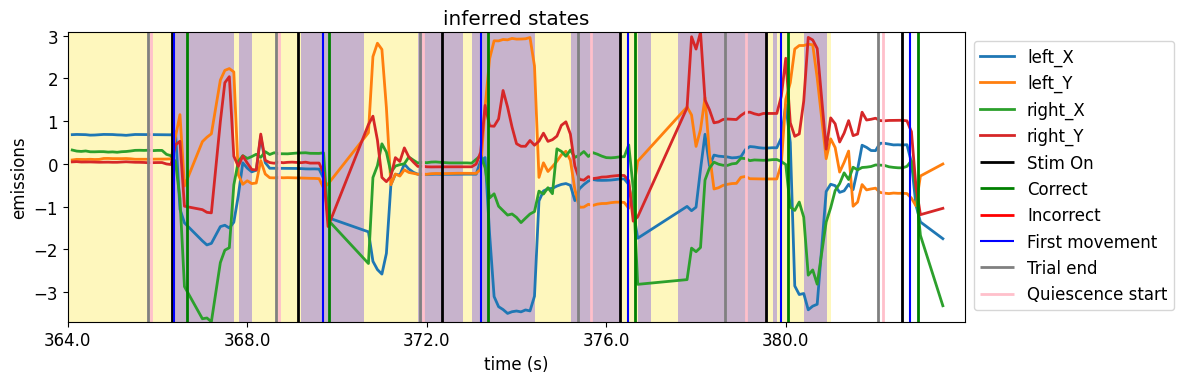

In [42]:
""" Plot raw traces over states """
init = 364*multiplier # First bin
inter = 20*multiplier
# traces_over_few_sates(init, empirical_data, session_trials, var_names)
traces_over_few_sates(init, inter, empirical_data, cont_trials, var_names, multiplier)

## Fit individual sessions

In [19]:
for m, mat in enumerate(idxs[0:10]):
    if len(mat) > 35: 
       
        mouse_name = mat[37:]
        session = mat[0:36]
        
        index_var = np.where(np.array(var_interest_map)==var_interest)[0][0]
        idx_init = idx_init_list[index_var]
        idx_end = idx_end_list[index_var]
        var_names = use_sets[index_var]

        # Get mouse data
        session_trials = session_all[mouse_name][session].reset_index()
        design_matrix = matrix_all[mouse_name][session][:,idx_init:idx_end]
        unnorm_mat = matrix_all_unnorm[mouse_name][session][var_names]  
        unnorm_mat['Bin'] = matrix_all_unnorm[mouse_name][session]['Bin']
            
        " Fit model with cross-validation"
        # Prepare data for cross-validation
        num_timesteps = np.shape(design_matrix)[0]
        emission_dim = np.shape(design_matrix)[1]
        shortened_array = np.array(design_matrix[:(num_timesteps // num_train_batches) * num_train_batches])
        train_emissions = jnp.stack(jnp.split(shortened_array, num_train_batches))
        
        # Initialize model with Kmeans
        test_arhmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags=num_lags, transition_matrix_stickiness=kappa)
        init_params, props = test_arhmm.initialize(key=jr.PRNGKey(1), method=method, emissions=shortened_array)  # for now all data
        
        # Compute inputs for required timelags
        my_inputs = compute_inputs(shortened_array, num_lags, emission_dim)
        train_inputs = jnp.stack(jnp.split(my_inputs, num_train_batches))
        
        # Fit model to all data with cross-validation
        val_lls, fit_params, init_params, baseline_lls = cross_validate_armodel(test_arhmm, 
                                                                            jr.PRNGKey(0), shortened_array, train_emissions, train_inputs, method, num_train_batches)


        " Re-fit with parameters of best fold "
        # Find best fold
        use_fold = np.where(val_lls==np.nanmax(val_lls))[0][0]
        print(use_fold)
        
        # Find parameters for best fold
        initial_probs = fit_params[0].probs[use_fold]
        transition_matrix = fit_params[1].transition_matrix[use_fold]
        emission_weights = fit_params[2].weights[use_fold]
        emission_biases = fit_params[2].biases[use_fold]
        emission_covariances = fit_params[2].covs[use_fold]        
        
        # Initialize new hmm
        new_arhmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags=num_lags)
        best_fold_params, props = new_arhmm.initialize(key=jr.PRNGKey(0), method=method,
                                        initial_probs=initial_probs,
                                        transition_matrix=transition_matrix,               
                                        emission_weights=emission_weights,
                                        emission_biases=emission_biases, 
                                        emission_covariances=emission_covariances,
                                        emissions=shortened_array)  # not sure if I need to include  
        
        # Get state estimates for validation data
        most_likely_states = new_arhmm.most_likely_states(best_fold_params, shortened_array, my_inputs)

        # Keep only enough states to explain 95% observations
        
        unique, counts = np.unique(most_likely_states, return_counts=True)
        threshold_count = threshold * len(most_likely_states)
        excluded_bins = 0
        remaining_states = list(counts.copy())
        for state in unique:
            size_smallest_state = np.nanmin(remaining_states)
            if size_smallest_state + excluded_bins < threshold_count:
                remaining_states[np.where(counts==size_smallest_state)[0][0]] = np.nan
                excluded_bins += size_smallest_state
        
        # Remove states below threshold
        new_states = np.array(most_likely_states).astype(float)
        exclude_states = np.where(np.isnan(np.array(remaining_states)))[0].astype(float)
        # Create a boolean mask to identify values to replace
        mask = np.isin(new_states, exclude_states)
        # Replace values in main_array with np.nan using the boolean mask
        new_states[mask] = np.nan

        new_states = most_likely_states
        
        " Plots "
        # Prepare data
        design_matrix_heading = pd.DataFrame(columns=var_names)
        design_matrix_heading[var_names] = design_matrix[0:len(most_likely_states)]  # TODO: need to understand why number is the same and whether it depends on lag
        bins = unnorm_mat[:(num_timesteps // num_train_batches) * num_train_batches]['Bin']
        design_matrix_heading['Bin'] = bins
        init = -10
        end = 15
        empirical_data = align_bin_design_matrix(init, end, event_type_list, session_trials, design_matrix_heading, new_states, multiplier)

    
        """ Stack trial states """
        trial_init = 30  # First trial to plot
        trials_to_plot = 30  # How many trials to plot (if very different will compromise readibility)
        plot_states_aligned_trial(trial_init, empirical_data, session_trials, bin_size, trials_to_plot, inverted_mapping=[])

        " Plot states stacked and aligned per trial type "
        plot_states_aligned(init, end, empirical_data, event_type_name, bin_size, inverted_mapping=[])
        
        # """ Plot states per trial epoch """
        # colors = sns.color_palette("viridis", num_states)
        # states_trial = states_per_trial_phase(empirical_data, session_trials)
        # plt.figure(figsize=[7, 5])
        # sns.histplot(x='label', hue=0, data=states_trial, stat = 'percent',
        #                     multiple="stack", legend=True, palette='viridis', alpha=0.3)  # stat='frequency',
        # plt.xlabel('Trial phase')
        # plt.legend(loc='upper left', bbox_to_anchor=(1, -0.5))
        # plt.xticks(rotation=45)
        # plt.tight_layout()
        # plt.title(mouse_name)
        # plt.show()
    
        """ Plot raw traces over states """
        init = 2500 # First bin
        inter = 200
        # traces_over_few_sates(init, empirical_data, session_trials, var_names)
        traces_over_few_sates(init, inter, empirical_data, session_trials, var_names, multiplier, inverted_mapping=[])


/tmp/ipykernel_17772/2086917471.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = matrix_all_unnorm[mouse_name][session]['Bin']


AttributeError: 'ArrayImpl' object has no attribute 'lower'